# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Authors:** Dhruti Shah, Mahdi Nobar
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [5]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

In [4]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

NameError: name 'os' is not defined

### 1.2 Region growing

Using two different homogenity criterion:
1. intensity > threshold
2. intensity difference between neighbors < threshold

We obtain two different results from the above two different criterion, shown below.

In [3]:
import numpy as np

In [4]:
# Intensity > threshold
def check_neighbors(seed_pt1, img, thresh, checked, mask):
    neigh = []
    seed_pt_i = seed_pt1[0]
    seed_pt_j = seed_pt1[1]
    for j in range(max(0,seed_pt_j-1),min(seed_pt_j+2,256)):
        for i in range(max(0,seed_pt_i-1),min(seed_pt_i+2,256)):
            if img[i][j].astype(int) > thresh and (i,j) not in checked and (i,j)!=(seed_pt_i, seed_pt_j):
            #if abs(img[i][j].astype(int)-img[seed_pt_i][seed_pt_j].astype(int)) < thresh and (i,j) not in checked and (i,j)!=(seed_pt_i, seed_pt_j):
                if (i,j) not in checked:
                    neigh += [(i,j)]
                    mask[i][j] = True
    return neigh, mask

def region_growing(mask, seed_pt, img, thresh):
    mask[seed_pt[0]][seed_pt[1]] = True
    to_check = [seed_pt]
    checked = []
    while(len(to_check)>0):
        neighbors = []
        for i in to_check:
            neigh, mask = check_neighbors(i, img, thresh, checked, mask)
            neighbors += neigh
            checked += neigh
        to_check = neighbors
    
    return mask

In [5]:
# Intensity difference between neighbors < threshold
def check_neighbors1(seed_pt1, img, thresh, checked, mask):
    neigh = []
    seed_pt_i = seed_pt1[0]
    seed_pt_j = seed_pt1[1]
    for j in range(max(0,seed_pt_j-1),min(seed_pt_j+2,256)):
        for i in range(max(0,seed_pt_i-1),min(seed_pt_i+2,256)):
            #if img[i][j].astype(int) > 69 and (i,j) not in checked and (i,j)!=(seed_pt_i, seed_pt_j):
            if abs(img[i][j].astype(int)-img[seed_pt_i][seed_pt_j].astype(int)) < thresh and (i,j) not in checked and (i,j)!=(seed_pt_i, seed_pt_j):
                if (i,j) not in checked:
                    neigh += [(i,j)]
                    mask[i][j] = True
    return neigh, mask

def region_growing1(mask, seed_pt, img, thresh):
    mask[seed_pt[0]][seed_pt[1]] = True
    to_check = [seed_pt]
    checked = []
    while(len(to_check)>0):
        neighbors = []
        for i in to_check:
            neigh, mask = check_neighbors1(i, img, thresh, checked, mask)
            neighbors += neigh
            checked += neigh
        to_check = neighbors
    
    return mask

In [6]:
mask = np.zeros([im_h, im_w]).astype(bool)
seed_pt = (im_h//2, im_w//2+20)
mask = region_growing(mask, seed_pt, brain_im, thresh=69)

mask1 = np.zeros([im_h, im_w]).astype(bool)
seed_pt = (im_h//2, im_w//2+20)
mask1 = region_growing1(mask1, seed_pt, brain_im, thresh=8)

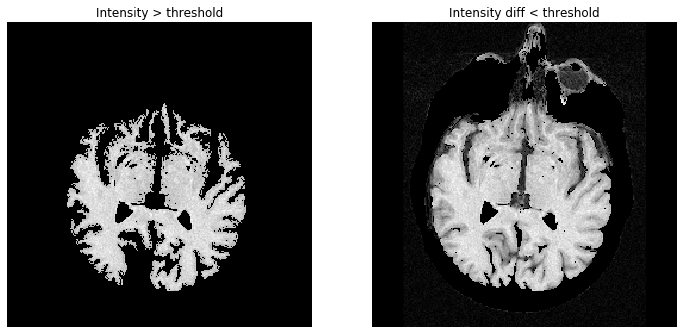

In [7]:
brain_im1 = brain_im.copy()
brain_im1[np.logical_not(mask)]=0

brain_im2 = brain_im.copy()
brain_im2[np.logical_not(mask1)]=0

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(brain_im1, cmap='gray')
ax[0].set_title('Intensity > threshold')
ax[0].axis('off')

ax[1].imshow(brain_im2, cmap='gray')
ax[1].set_title('Intensity diff < threshold')
ax[1].axis('off')

plt.show()

#### Post - processing
For the first image, we see that some parts of the brain are not detected. For the second one, we see that the entire brain in addition to other pixels are detected. We can correctly get only the brain pixels by post-processing the second image.
We have 2 steps. Firstly, we threshold the image, to remove some of the unwanted components. 

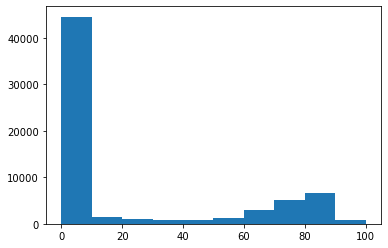

In [8]:
plt.hist(brain_im2.ravel());
plt.show()

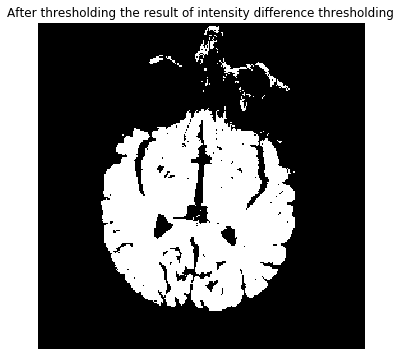

In [9]:
mask1 = brain_im2 > 50 #second region growing method is again been thresholded.

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(mask1, cmap='gray')
ax.set_title('After thresholding the result of intensity difference thresholding')
ax.axis('off')

plt.show()

Then we detect the connected components, and discard those whose size is smaller than a certain threshold. In this way, we get an accurate segment of the brain.

from scipy import ndimage as ndi

In [10]:
from scipy import ndimage as ndi

In [11]:
label_objects, nb_labels = ndi.label(mask1)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 80
mask_sizes[0] = 0
mask_cleaned = mask_sizes[label_objects]

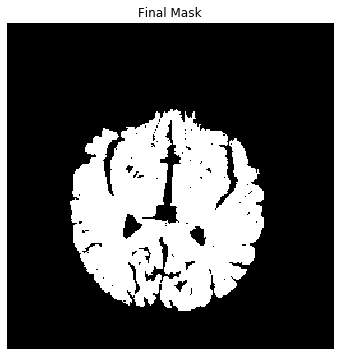

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(mask_cleaned, cmap='gray')
ax.set_title('Final Mask')
ax.axis('off')

plt.show()

In [13]:
print('Size of brain (in pixels) is:', np.sum(mask_cleaned))

Size of brain (in pixels) is: 16177


### 1.3 Contour detection
Add your implementation and discussion

In [14]:
import skimage.filters
from skimage import measure
from skimage import morphology
from skimage.feature import canny
import scipy.ndimage as ndimage
from skimage.segmentation import active_contour

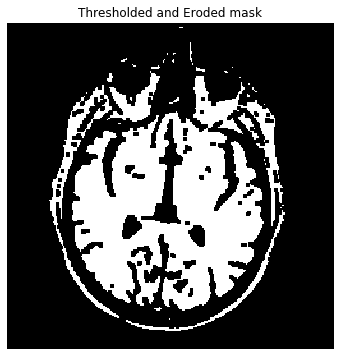

In [15]:
brain_im2 = skimage.filters.gaussian(brain_im,sigma=0.01)
mask = morphology.binary_erosion(brain_im2 > 0.2, selem=np.ones([3,3]))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(mask, cmap='gray')
ax.set_title('Thresholded and Eroded mask')
ax.axis('off')

plt.show()

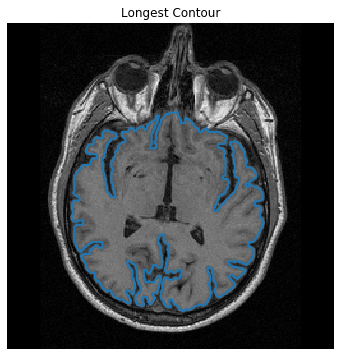

In [16]:
contours = measure.find_contours(mask, 0.24)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im2, cmap='gray')
ax.set_title('Longest Contour')
ax.axis('off')

max_len = 0
longest_c = contours[0]
index_longest = 0

for n, contour in enumerate(contours):
    if len(contour) > max_len:
        max_len = len(contour)
        longest_c = contour
        index_longest = n
    #ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.plot(longest_c[:, 1], longest_c[:, 0], linewidth=2)
plt.show()

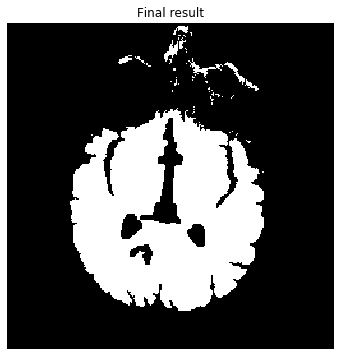

In [17]:
#ASK why mask1? whereas contours are calculated from mask!!
mask_longest = ndimage.binary_fill_holes(mask1)
mask_holes = np.zeros(brain_im.shape).astype(bool)

for n, contour in enumerate(contours):
    mask_temp = np.zeros(brain_im.shape).astype(bool)
    if n!=index_longest:
        if(len(contour)>60):
            mask_temp[contour[:,0].astype(int),contour[:,1].astype(int)] = True
            mask_temp = ndimage.binary_fill_holes(mask_temp)
            mask_holes = np.logical_or((mask_temp),mask_holes)

final_mask = np.logical_and(mask_longest, np.logical_not(mask_holes))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(final_mask, cmap='gray')
ax.set_title('Final result')
ax.axis('off')

plt.show()

In [18]:
print('Size of brain (in pixels) is:', np.sum(final_mask))

Size of brain (in pixels) is: 16539


### 1.4 Additional method(s)
Add your implementation and discussion

#### 1.4.3 Snakes: Active Contours Method
Active contour is a type of segmentation technique which can be defined as use of energy forces and constraints for segregation of the pixels of interest from the image for further processing and analysis. 
Here we study 'snake' model of active contours. A snake is an energy-minimizing spline guided by external constraint forces and influenced by image forces that pull it toward edges.

First, we define initial spline for the active contour method in order to include the entire brain. For this end, we consider a circle which contains the brain as shown with yello dash on figure bellow.
Afterwards, we apply gaussian blur with 3by3 kernel to the image to reduce the noise effect, and feed in the filtered image to _Skimage_ 'active contour model'.
This module requires input parameters including:
- _alpha_ is the length shape parameter of snake spline. Higher _alpha_ values makes snake contract faster. 
- _beta_ is the smoothness parameter of the spline. Higher _beta_ means that the snake spline is smoother.
- _w_line_ and _w_edge_ are the parameter that controls attraction to brightness and edges in order. 

Initially our attempt to tune the parameters of the snake spline to be able to fit it directly to the brain was not successful. Neverthless, we could acuire the first contour that detects the edges of the skull as shown bellow.  


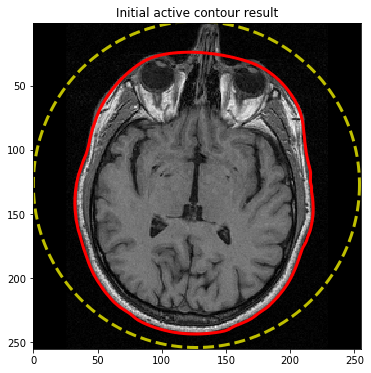

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
img = brain_im

s = np.linspace(0, 2*np.pi, 400)
r = 127 + 127*np.sin(s)
c = 127 + 127*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(img, 3),
                       init, alpha=0.015, beta=10, gamma=0.001, w_line=0, w_edge=1,
                       coordinates='rc')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=3)
ax.axis([0, img.shape[1]-1, img.shape[0]-1, 1])
ax.set_title('Initial active contour result')

# Convert the contour into a closed path
from matplotlib import path
closed_snake = path.Path(snake)
# Get the points that lie within the closed path
idx = np.array([[(j,i) for i in range(img.shape[0])] for j in range(img.shape[1])]).reshape(np.prod(img.shape),2)
# mask_snake = binary image True inside the snake
mask_snake = closed_snake.contains_points(idx).reshape(img.shape)

We realized that this method is sensative to the initial contour and fine tuning of the input parameters. Thus, we provided the detected skull spline at first step as the initial contour for the second attempt. This time after gaussina blurring, we also binarize and erode the input image in order to make the edges between the skull and the brain more distinguishable. Moreover, we realized that the method is adjusted by either repulsion degree to the darkness. THerefore, we also whiten the background to cancel its effect from contour detection.  


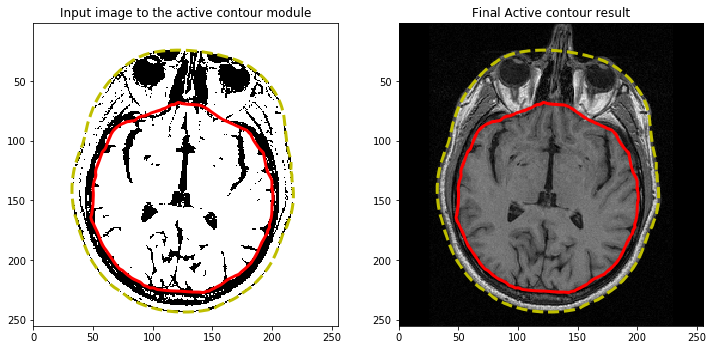

Size of brain (in pixels) is: 18841


In [7]:
from skimage import morphology

plt.close()
img2 = brain_im
img2 = skimage.filters.gaussian(img2,sigma=0.01)
img2 = morphology.binary_erosion(img2 > 0.2, selem=np.ones([1,1]))
img2= img2+~mask_snake


s = np.linspace(0, 2*np.pi, 400)
r = 127 + 127*np.sin(s)
c = 127 + 127*np.cos(s)
init = np.array([r, c]).T


snake1 = active_contour(gaussian(img2, 3),
                       snake, alpha=1, beta=10, gamma=0.001, w_line=-1, w_edge=2,convergence=0.01, boundary_condition='periodic',
                       coordinates='rc')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img2, cmap=plt.cm.gray)
ax[0].plot(snake[:, 1], snake[:, 0], '--y', lw=3)
ax[0].plot(snake1[:, 1], snake1[:, 0], '-r', lw=3)
ax[0].axis([0, img.shape[1]-1, img.shape[0]-1, 1])
ax[0].set_title('Input image to the active contour module')

ax[1].imshow(brain_im, cmap=plt.cm.gray)
ax[1].plot(snake[:, 1], snake[:, 0], '--y', lw=3)
ax[1].plot(snake1[:, 1], snake1[:, 0], '-r', lw=3)
ax[1].axis([0, img.shape[1]-1, img.shape[0]-1, 1])
ax[1].set_title('Final Active contour result')
plt.show()

# Convert the contour into a closed path
from matplotlib import path
closed_snake1 = path.Path(snake1)
# Get the points that lie within the closed path
idx = np.array([[(j,i) for i in range(img2.shape[0])] for j in range(img2.shape[1])]).reshape(np.prod(img2.shape),2)
# mask_snake = binary image True inside the snake
mask_snake1 = closed_snake1.contains_points(idx).reshape(img2.shape)

print('Size of brain (in pixels) is:', np.sum(mask_snake1))

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [21]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


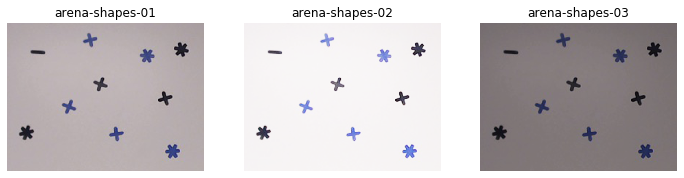

In [22]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

In [23]:
from skimage.color import rgb2hsv, hsv2rgb
import skimage.color
from scipy.spatial import distance

In [24]:
def illumination_invariance(im):
    hsv_im = rgb2hsv(im)
    temp = np.ones(hsv_im[:,:,2].shape)
    hsv_im[:,:,2] = np.minimum(hsv_im[:,:,2]+(1-np.mean(hsv_im[:,:,2])), temp)
    return hsv2rgb(hsv_im)

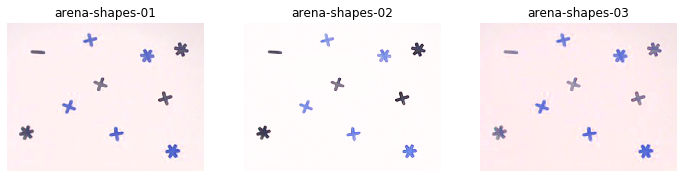

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    im1 = illumination_invariance(im)
    ax.imshow((im1))
    ax.axis('off')
    ax.set_title(nm)

plt.show()

In [26]:
def count_shapes(image, gray_thresh, dist_thresh):
    img = illumination_invariance(image)
    #plt.hist(skimage.color.rgb2gray(img).ravel(), bins = 50)
    mask = skimage.color.rgb2gray(img)<gray_thresh
    #plt.imshow(mask, cmap='gray')
    
    blobs_labels = measure.label(mask, background=0)
    #plt.imshow(blobs_labels, cmap='nipy_spectral')
    
    labels = np.sort(np.unique(blobs_labels.ravel()))[1:]
    seen_colors = []
    count_shapes = []
    for i in labels:
        mask1 = [blobs_labels==i]
        rgb_mean = np.mean(img[tuple(mask1)], axis=0)
        seen_colors.append(rgb_mean)
        
    count1 = np.sum(distance.cdist(seen_colors, seen_colors)[0,:] > dist_thresh)
    count2 = len(labels) - count1
    return count1, count2

In [27]:
for ind, i in enumerate(images):
    print('For image',ind,'number of shapes of each color: ',count_shapes(i,0.7,0.2))

For image 0 number of shapes of each color:  (5, 5)
For image 1 number of shapes of each color:  (5, 5)
For image 2 number of shapes of each color:  (5, 5)


### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

In [28]:
def count_area(image, gray_thresh, dist_thresh):
    img = illumination_invariance(image)
    #plt.hist(skimage.color.rgb2gray(img).ravel(), bins = 50)
    mask = skimage.color.rgb2gray(img)<gray_thresh
    #plt.imshow(mask, cmap='gray')
    
    blobs_labels = measure.label(mask, background=0)
    #plt.imshow(blobs_labels, cmap='nipy_spectral')
    
    labels = np.sort(np.unique(blobs_labels.ravel()))[1:]
    seen_colors = []
    count_shapes = []
    for i in labels:
        mask1 = [blobs_labels==i]
        rgb_mean = np.mean(img[tuple(mask1)], axis=0)
        seen_colors.append(rgb_mean)
        
    colors = (distance.cdist(seen_colors, seen_colors)[0,:] > dist_thresh)
    color1_labels = np.nonzero(colors)[0]+1
    color2_labels = np.nonzero(np.logical_not(colors))[0]+1
    
    num_pixels1 = 0
    num_pixels2 = 0
    
    for i in color1_labels:
        num_pixels1 += np.sum(blobs_labels==i)
    for i in color2_labels:
        num_pixels2 += np.sum(blobs_labels==i)
        
    return num_pixels1, num_pixels2

In [29]:
for ind, i in enumerate(images):
    print('For image',ind,'number of pixels of each color: ',count_area(i,0.7,0.2))

For image 0 number of pixels of each color:  (4834, 5029)
For image 1 number of pixels of each color:  (4415, 4126)
For image 2 number of pixels of each color:  (4425, 4933)
